In [27]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# Dataset

In [ ]:
TRAIN_DIR = os.path.join(os.curdir, 'images', 'train')
VAL_DIR = os.path.join(os.curdir, 'images', 'val')
TRAIN_MASKS_DIR = os.path.join(os.curdir, 'masks', 'train')
VAL_MASKS_DIR = os.path.join(os.curdir, 'masks', 'val')

# import torchvision.transforms as T
import albumentations as A
import torch

# def get_image_transform(image_size=(512, 512), mean=None, std=None):
#     return T.Compose([
#         T.Resize(image_size),
#         T.ToTensor(),
#         T.Normalize(mean, std)
#     ])

# def get_mask_transform(image_size=(512, 512)):
#     return T.Compose([
#         T.Resize(image_size, interpolation=T.InterpolationMode.NEAREST),
#         T.PILToTensor()
#     ])

def get_training_augmentation(image_size=(512, 512), mean=None, std=None):
    conservative = [
        A.HorizontalFlip(p=0.5),
        # A.SmallestMaxSize(max_size=image_size[0], p=1),
        # A.RandomResizedCrop(size=image_size, scale=(0.8, 1.0), p=1),
        A.Resize(height=image_size[0], width=image_size[1], p=1),
        A.Rotate(limit=10, p=0.5),
        A.GaussianBlur(blur_limit=(3, 5), p=0.3),
        A.HueSaturationValue(p=0.5),
        A.ElasticTransform(alpha=1.0, sigma=40, p=0.3),
        A.CoarseDropout(hole_height_range=(10, 20), hole_width_range=(10, 20), p=0.2),
        A.RandomFog(fog_coef_range=(0.05, 0.15), p=0.2),
        # A.ColorJitter(contrast=0.4, brightness=0.4, hue=0.05, p=0.1),
        A.Normalize(mean=mean, std=std),
        A.pytorch.transforms.ToTensorV2()
    ]
    return A.Compose(conservative)

def get_validation_augmentation(image_size=(512, 512), mean=None, std=None):
    val_transform = [
        A.Resize(height=image_size[0], width=image_size[1], p=1),
        A.Normalize(mean=mean, std=std),
        A.pytorch.transforms.ToTensorV2()
    ]
    return A.Compose(val_transform)

class COCOSegDataset(Dataset):
    CLASSES = ['unlabeled', 'fire', 'smoke']

    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.images)

    def convert_mask(self, mask_img):
        arr = np.array(mask_img)  # grayscale [H, W] with values like 0, 127, 254
        out = np.zeros_like(arr, dtype=np.uint8)

        mapping = {0: 0, 127: 1, 254: 2}
        for k, v in mapping.items():
            out[arr == k] = v

        return out

    def __getitem__(self, i):
        img_path = os.path.join(self.images_dir, self.images[i])
        mask_path = os.path.join(self.masks_dir, self.images[i].replace('.jpg', '.png'))
        
        image = Image.open(img_path).convert('RGB')
        mask = self.convert_mask(Image.open(mask_path).convert('L'))

        # if self.image_transform:
        #     image = self.image_transform(image)
        
        # if self.mask_transform:
        #     mask_pil = Image.fromarray(mask.astype(np.uint8), mode='L')
        #     mask = self.mask_transform(mask_pil).squeeze(0).long()

        if self.transform:
            augmented = self.transform(image=np.array(image), mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.long()

    def visualize(self, **images):
        n = len(images)
        plt.figure(figsize=(16,5))
        for i, (title, img) in enumerate(images.items()):
            plt.subplot(1, n, i + 1)
            plt.title(title)
            if title == 'Image':
                plt.imshow(img)
            else:
                plt.imshow(img, cmap='gray')
        plt.show()

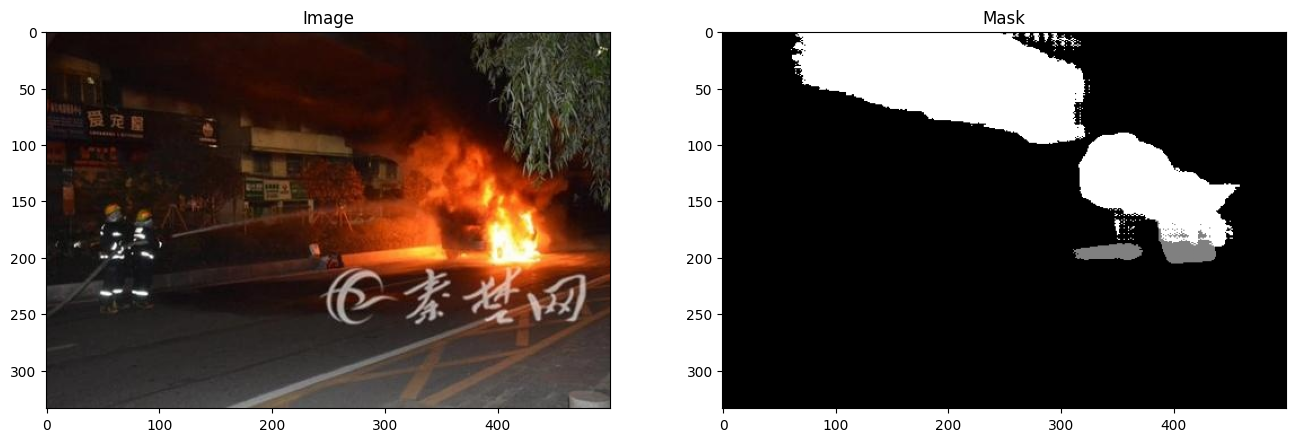

In [47]:
dataset = COCOSegDataset(TRAIN_DIR, TRAIN_MASKS_DIR)
image, mask = dataset[3]
dataset.visualize(Image=image, Mask=mask)

# Model creation and training

In [ ]:
import os
import torch
from torch import nn, optim
from tqdm import tqdm
from torch.amp import GradScaler, autocast
import segmentation_models_pytorch as smp

def compute_map50(tp, fp, num_of_classes):
    """
    Compute mAP@50 for multi-class segmentation using TP and FP tensors.
    Args:
        tp: torch.Tensor, shape (N, C) - true positives per image and class
        fp: torch.Tensor, shape (N, C) - false positives per image and class
        num_of_classes: int, number of classes
    Returns:
        mean_ap: float, mean AP@50 over all classes
        ap_per_class: list of AP@50 for each class
    """
    aps = []
    eps = 1e-7
    
    tp_sum = tp.sum(dim=0).float()
    fp_sum = fp.sum(dim=0).float()
    for cls in range(num_of_classes):
        precision = tp_sum[cls] / (tp_sum[cls] + fp_sum[cls] + eps)
        ap = precision.item()  # With a single threshold, AP ≈ precision at recall
        aps.append(ap)
    mean_ap = sum(aps) / len(aps)
    return mean_ap, aps

def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10, batch_size=4,
                checkpoint_dir='checkpoints', num_of_classes = 3, device='cuda', use_amp=False):
    os.makedirs(checkpoint_dir, exist_ok=True)

    model.to(device)
    scaler = GradScaler(enabled=use_amp)

    best_val_iou, best_val_f1 = 0.0, 0.0
    training_step_outputs = []
    validation_step_outputs = []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # --- Training phase ---
        train_loss = 0.0
        model.train()
        for images, masks in tqdm(train_loader, desc="Training"):
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            with autocast(enabled=use_amp, device_type='cuda', dtype=torch.float16):
                outputs = model(images)
                loss = loss_fn(outputs, masks)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()

            # Convert probabilities to predicted class labels
            pred_mask = outputs.argmax(dim=1)
            # Compute true positives, false positives, false negatives, and true negatives
            tp, fp, fn, tn = smp.metrics.get_stats(
                pred_mask, masks, mode="multiclass", num_classes=num_of_classes
            )
            training_step_outputs.append({
                "tp": tp,
                "fp": fp,
                "fn": fn,
                "tn": tn
            })

        train_loss /= len(train_loader)

        tp = torch.cat([x["tp"] for x in training_step_outputs])
        fp = torch.cat([x["fp"] for x in training_step_outputs])
        fn = torch.cat([x["fn"] for x in training_step_outputs])
        tn = torch.cat([x["tn"] for x in training_step_outputs])
        training_step_outputs.clear()

        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro")
        print(f"Per-image IoU: {per_image_iou:.4f} | Dataset IoU: {dataset_iou:.4f}")

        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="macro")
        precision = smp.metrics.precision(tp, fp, fn, tn, reduction=None)
        recall = smp.metrics.recall(tp, fp, fn, tn, reduction=None)
        precision, recall = precision.mean(dim=0), recall.mean(dim=0)
        print(f"Precision:\nFire:\t {precision[1]:.4f}\nSmoke:\t {precision[2]:.4f}")
        print(f"Recall:\nFire:\t {recall[1]:.4f}\nSmoke:\t {recall[2]:.4f}")
        print(f"F1 Score: {f1_score:.4f}")
        mean_ap, _ = compute_map50(tp, fp, num_of_classes)
        print(f"mAP@50: {mean_ap:.4f}")
        print(f"Train Loss: {train_loss:.4f}\n")

        # --- Validation phase ---
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc="Validation"):
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, masks)
                val_loss += loss.item()

                # Convert probabilities to predicted class labels
                pred_mask = outputs.argmax(dim=1)
                # Compute true positives, false positives, false negatives, and true negatives
                tp, fp, fn, tn = smp.metrics.get_stats(
                    pred_mask, masks, mode="multiclass", num_classes=num_of_classes
                )
                validation_step_outputs.append({
                    "tp": tp,
                    "fp": fp,
                    "fn": fn,
                    "tn": tn
                })

        val_loss /= len(val_loader)

        tp = torch.cat([x["tp"] for x in validation_step_outputs])
        fp = torch.cat([x["fp"] for x in validation_step_outputs])
        fn = torch.cat([x["fn"] for x in validation_step_outputs])
        tn = torch.cat([x["tn"] for x in validation_step_outputs])
        validation_step_outputs.clear()

        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        print(f"Per-image IoU: {per_image_iou:.4f} | Dataset IoU: {dataset_iou:.4f}")
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="macro")
        precision = smp.metrics.precision(tp, fp, fn, tn, reduction=None)
        recall = smp.metrics.recall(tp, fp, fn, tn, reduction=None)
        precision, recall = precision.mean(dim=0), recall.mean(dim=0)
        print(f"Precision:\nFire:\t {precision[1]:.4f}\nSmoke:\t {precision[2]:.4f}")
        print(f"Recall:\nFire:\t {recall[1]:.4f}\nSmoke:\t {recall[2]:.4f}")
        print(f"F1 Score: {f1_score:.4f}")
        mean_ap, _ = compute_map50(tp, fp, num_of_classes)
        print(f"mAP@50: {mean_ap:.4f}")
        print(f"Val Loss: {val_loss:.4f}")

        # save the best weights
        if dataset_iou > best_val_iou or f1_score > best_val_f1:
            best_val_iou = dataset_iou
            best_val_f1 = f1_score
            weights_path = os.path.join(checkpoint_dir, "best_weights.pth")
            torch.save(model.state_dict(), weights_path)
            print(f"Saved new best weights (Loss = {val_loss:.4f})")

    print("\nTraining complete.")

In [ ]:
import segmentation_models_pytorch as smp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IMAGE_SIZE = (512, 512)
BATCH_SIZE = 2
ENCODER_NAME = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
params = smp.encoders.get_preprocessing_params(ENCODER_NAME, ENCODER_WEIGHTS)
mean = params['mean']
std = params['std']

dataset = COCOSegDataset(TRAIN_DIR, TRAIN_MASKS_DIR, 
                         transform=get_training_augmentation(IMAGE_SIZE, mean, std))
val_dataset = COCOSegDataset(VAL_DIR, VAL_MASKS_DIR,
                             transform=get_validation_augmentation(IMAGE_SIZE, mean, std))
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

EPOCHS = 20
T_MAX = EPOCHS * len(train_loader)
OUT_CLASSES = len(dataset.CLASSES)

model = smp.DeepLabV3Plus(
    encoder_name=ENCODER_NAME,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=3,
    classes=OUT_CLASSES,
    encoder_output_stride=8,
    encoder_depth=5
)

# loss_weights = [1.0, 1.3, 1.5]
# loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(loss_weights, device=device))
# loss_fn = smp.losses.FocalLoss(mode='multiclass', gamma=2.0)
loss_fn = smp.losses.TverskyLoss(mode='multiclass', alpha=0.3, beta=0.7, smooth=1e-6)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [5]:
train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=EPOCHS,
            batch_size=BATCH_SIZE, checkpoint_dir='checkpoints', num_of_classes=OUT_CLASSES,
            device=device, use_amp=False)


Epoch 1/20


Training: 100%|██████████| 571/571 [14:38<00:00,  1.54s/it]


Per-image IoU: 0.7267 | Dataset IoU: 0.5608
Precision:
Fire:	 0.5082
Smoke:	 0.5581
Recall:
Fire:	 0.8259
Smoke:	 0.8100
F1 Score: 0.7021
mAP@50: 0.6518
Train Loss: 0.3107



Validation: 100%|██████████| 154/154 [00:57<00:00,  2.69it/s]


Per-image IoU: 0.8265 | Dataset IoU: 0.8193
Precision:
Fire:	 0.7605
Smoke:	 0.5525
Recall:
Fire:	 0.7342
Smoke:	 0.7915
F1 Score: 0.8029
mAP@50: 0.7860
Val Loss: 0.2360
Saved new best weights (Loss = 0.2360)

Epoch 2/20


Training: 100%|██████████| 571/571 [14:18<00:00,  1.50s/it]


Per-image IoU: 0.8072 | Dataset IoU: 0.6717
Precision:
Fire:	 0.6299
Smoke:	 0.6344
Recall:
Fire:	 0.8322
Smoke:	 0.8118
F1 Score: 0.7953
mAP@50: 0.7718
Train Loss: 0.2161



Validation: 100%|██████████| 154/154 [00:57<00:00,  2.69it/s]


Per-image IoU: 0.8102 | Dataset IoU: 0.8022
Precision:
Fire:	 0.6947
Smoke:	 0.5550
Recall:
Fire:	 0.8114
Smoke:	 0.7922
F1 Score: 0.7925
mAP@50: 0.7533
Val Loss: 0.2321

Epoch 3/20


Training: 100%|██████████| 571/571 [14:21<00:00,  1.51s/it]


Per-image IoU: 0.8272 | Dataset IoU: 0.6985
Precision:
Fire:	 0.6628
Smoke:	 0.6625
Recall:
Fire:	 0.8485
Smoke:	 0.8117
F1 Score: 0.8154
mAP@50: 0.7946
Train Loss: 0.1915



Validation: 100%|██████████| 154/154 [00:57<00:00,  2.66it/s]


Per-image IoU: 0.8375 | Dataset IoU: 0.8294
Precision:
Fire:	 0.7000
Smoke:	 0.6114
Recall:
Fire:	 0.8770
Smoke:	 0.7470
F1 Score: 0.8151
mAP@50: 0.7828
Val Loss: 0.2060
Saved new best weights (Loss = 0.2060)

Epoch 4/20


Training: 100%|██████████| 571/571 [13:58<00:00,  1.47s/it]


Per-image IoU: 0.8357 | Dataset IoU: 0.7136
Precision:
Fire:	 0.6700
Smoke:	 0.6777
Recall:
Fire:	 0.8481
Smoke:	 0.8082
F1 Score: 0.8267
mAP@50: 0.8069
Train Loss: 0.1820



Validation: 100%|██████████| 154/154 [00:57<00:00,  2.69it/s]


Per-image IoU: 0.8413 | Dataset IoU: 0.8350
Precision:
Fire:	 0.7390
Smoke:	 0.5887
Recall:
Fire:	 0.8634
Smoke:	 0.7785
F1 Score: 0.8291
mAP@50: 0.7992
Val Loss: 0.1957
Saved new best weights (Loss = 0.1957)

Epoch 5/20


Training: 100%|██████████| 571/571 [14:36<00:00,  1.54s/it]


Per-image IoU: 0.8358 | Dataset IoU: 0.7179
Precision:
Fire:	 0.6903
Smoke:	 0.6759
Recall:
Fire:	 0.8471
Smoke:	 0.8136
F1 Score: 0.8300
mAP@50: 0.8078
Train Loss: 0.1798



Validation: 100%|██████████| 154/154 [00:57<00:00,  2.68it/s]


Per-image IoU: 0.8006 | Dataset IoU: 0.7858
Precision:
Fire:	 0.7033
Smoke:	 0.5605
Recall:
Fire:	 0.8584
Smoke:	 0.7913
F1 Score: 0.7833
mAP@50: 0.7322
Val Loss: 0.2179

Epoch 6/20


Training: 100%|██████████| 571/571 [14:00<00:00,  1.47s/it]


Per-image IoU: 0.8440 | Dataset IoU: 0.7264
Precision:
Fire:	 0.6869
Smoke:	 0.6936
Recall:
Fire:	 0.8610
Smoke:	 0.8289
F1 Score: 0.8360
mAP@50: 0.8126
Train Loss: 0.1750



Validation: 100%|██████████| 154/154 [00:56<00:00,  2.71it/s]


Per-image IoU: 0.8533 | Dataset IoU: 0.8459
Precision:
Fire:	 0.7967
Smoke:	 0.7366
Recall:
Fire:	 0.8145
Smoke:	 0.7250
F1 Score: 0.8358
mAP@50: 0.8285
Val Loss: 0.2043
Saved new best weights (Loss = 0.2043)

Epoch 7/20


Training: 100%|██████████| 571/571 [14:46<00:00,  1.55s/it]


Per-image IoU: 0.8465 | Dataset IoU: 0.7320
Precision:
Fire:	 0.6918
Smoke:	 0.6933
Recall:
Fire:	 0.8638
Smoke:	 0.8265
F1 Score: 0.8400
mAP@50: 0.8165
Train Loss: 0.1654



Validation: 100%|██████████| 154/154 [00:56<00:00,  2.74it/s]


Per-image IoU: 0.8419 | Dataset IoU: 0.8328
Precision:
Fire:	 0.7131
Smoke:	 0.6809
Recall:
Fire:	 0.8500
Smoke:	 0.7456
F1 Score: 0.8186
mAP@50: 0.7807
Val Loss: 0.2085

Epoch 8/20


Training: 100%|██████████| 571/571 [14:43<00:00,  1.55s/it]


Per-image IoU: 0.8525 | Dataset IoU: 0.7408
Precision:
Fire:	 0.7051
Smoke:	 0.7044
Recall:
Fire:	 0.8664
Smoke:	 0.8273
F1 Score: 0.8462
mAP@50: 0.8238
Train Loss: 0.1633



Validation: 100%|██████████| 154/154 [00:56<00:00,  2.72it/s]


Per-image IoU: 0.8556 | Dataset IoU: 0.8486
Precision:
Fire:	 0.7724
Smoke:	 0.7029
Recall:
Fire:	 0.8384
Smoke:	 0.7444
F1 Score: 0.8356
mAP@50: 0.8178
Val Loss: 0.1974
Saved new best weights (Loss = 0.1974)

Epoch 9/20


Training: 100%|██████████| 571/571 [14:46<00:00,  1.55s/it]


Per-image IoU: 0.8555 | Dataset IoU: 0.7472
Precision:
Fire:	 0.7030
Smoke:	 0.7098
Recall:
Fire:	 0.8797
Smoke:	 0.8279
F1 Score: 0.8507
mAP@50: 0.8269
Train Loss: 0.1583



Validation: 100%|██████████| 154/154 [00:57<00:00,  2.66it/s]


Per-image IoU: 0.8498 | Dataset IoU: 0.8430
Precision:
Fire:	 0.7656
Smoke:	 0.6028
Recall:
Fire:	 0.8479
Smoke:	 0.7809
F1 Score: 0.8365
mAP@50: 0.8092
Val Loss: 0.1924
Saved new best weights (Loss = 0.1924)

Epoch 10/20


Training: 100%|██████████| 571/571 [14:54<00:00,  1.57s/it]


Per-image IoU: 0.8574 | Dataset IoU: 0.7505
Precision:
Fire:	 0.7096
Smoke:	 0.7047
Recall:
Fire:	 0.8728
Smoke:	 0.8391
F1 Score: 0.8530
mAP@50: 0.8289
Train Loss: 0.1530



Validation: 100%|██████████| 154/154 [00:56<00:00,  2.74it/s]


Per-image IoU: 0.8621 | Dataset IoU: 0.8559
Precision:
Fire:	 0.8076
Smoke:	 0.7281
Recall:
Fire:	 0.8109
Smoke:	 0.7473
F1 Score: 0.8428
mAP@50: 0.8362
Val Loss: 0.1969
Saved new best weights (Loss = 0.1969)

Epoch 11/20


Training: 100%|██████████| 571/571 [14:00<00:00,  1.47s/it]


Per-image IoU: 0.8603 | Dataset IoU: 0.7502
Precision:
Fire:	 0.7108
Smoke:	 0.7146
Recall:
Fire:	 0.8725
Smoke:	 0.8394
F1 Score: 0.8527
mAP@50: 0.8291
Train Loss: 0.1536



Validation: 100%|██████████| 154/154 [00:56<00:00,  2.73it/s]


Per-image IoU: 0.8428 | Dataset IoU: 0.8338
Precision:
Fire:	 0.7751
Smoke:	 0.6779
Recall:
Fire:	 0.8530
Smoke:	 0.7558
F1 Score: 0.8304
mAP@50: 0.8067
Val Loss: 0.1975

Epoch 12/20


Training: 100%|██████████| 571/571 [13:49<00:00,  1.45s/it]


Per-image IoU: 0.8630 | Dataset IoU: 0.7567
Precision:
Fire:	 0.7142
Smoke:	 0.7207
Recall:
Fire:	 0.8766
Smoke:	 0.8380
F1 Score: 0.8572
mAP@50: 0.8343
Train Loss: 0.1530



Validation: 100%|██████████| 154/154 [00:55<00:00,  2.75it/s]


Per-image IoU: 0.8611 | Dataset IoU: 0.8541
Precision:
Fire:	 0.7485
Smoke:	 0.6842
Recall:
Fire:	 0.8566
Smoke:	 0.7351
F1 Score: 0.8429
mAP@50: 0.8226
Val Loss: 0.1946
Saved new best weights (Loss = 0.1946)

Epoch 13/20


Training: 100%|██████████| 571/571 [14:33<00:00,  1.53s/it]


Per-image IoU: 0.8637 | Dataset IoU: 0.7563
Precision:
Fire:	 0.7096
Smoke:	 0.7214
Recall:
Fire:	 0.8786
Smoke:	 0.8389
F1 Score: 0.8569
mAP@50: 0.8353
Train Loss: 0.1522



Validation: 100%|██████████| 154/154 [00:56<00:00,  2.73it/s]


Per-image IoU: 0.8656 | Dataset IoU: 0.8595
Precision:
Fire:	 0.7837
Smoke:	 0.7398
Recall:
Fire:	 0.8160
Smoke:	 0.7479
F1 Score: 0.8441
mAP@50: 0.8374
Val Loss: 0.1973
Saved new best weights (Loss = 0.1973)

Epoch 14/20


Training: 100%|██████████| 571/571 [15:15<00:00,  1.60s/it]


Per-image IoU: 0.8657 | Dataset IoU: 0.7592
Precision:
Fire:	 0.7176
Smoke:	 0.7204
Recall:
Fire:	 0.8800
Smoke:	 0.8427
F1 Score: 0.8588
mAP@50: 0.8367
Train Loss: 0.1471



Validation: 100%|██████████| 154/154 [00:56<00:00,  2.74it/s]


Per-image IoU: 0.8510 | Dataset IoU: 0.8432
Precision:
Fire:	 0.7441
Smoke:	 0.6633
Recall:
Fire:	 0.8594
Smoke:	 0.7926
F1 Score: 0.8349
mAP@50: 0.8077
Val Loss: 0.1876

Epoch 15/20


Training: 100%|██████████| 571/571 [14:50<00:00,  1.56s/it]


Per-image IoU: 0.8692 | Dataset IoU: 0.7668
Precision:
Fire:	 0.7314
Smoke:	 0.7245
Recall:
Fire:	 0.8847
Smoke:	 0.8498
F1 Score: 0.8641
mAP@50: 0.8417
Train Loss: 0.1452



Validation: 100%|██████████| 154/154 [00:56<00:00,  2.73it/s]


Per-image IoU: 0.8590 | Dataset IoU: 0.8517
Precision:
Fire:	 0.7931
Smoke:	 0.6691
Recall:
Fire:	 0.8163
Smoke:	 0.7600
F1 Score: 0.8400
mAP@50: 0.8275
Val Loss: 0.1931

Epoch 16/20


Training: 100%|██████████| 571/571 [14:55<00:00,  1.57s/it]


Per-image IoU: 0.8707 | Dataset IoU: 0.7709
Precision:
Fire:	 0.7282
Smoke:	 0.7352
Recall:
Fire:	 0.8872
Smoke:	 0.8512
F1 Score: 0.8669
mAP@50: 0.8428
Train Loss: 0.1384



Validation: 100%|██████████| 154/154 [00:56<00:00,  2.73it/s]


Per-image IoU: 0.8537 | Dataset IoU: 0.8454
Precision:
Fire:	 0.8336
Smoke:	 0.7016
Recall:
Fire:	 0.7570
Smoke:	 0.7478
F1 Score: 0.8274
mAP@50: 0.8368
Val Loss: 0.2124

Epoch 17/20


Training: 100%|██████████| 571/571 [14:18<00:00,  1.50s/it]


Per-image IoU: 0.8726 | Dataset IoU: 0.7715
Precision:
Fire:	 0.7275
Smoke:	 0.7420
Recall:
Fire:	 0.8860
Smoke:	 0.8481
F1 Score: 0.8673
mAP@50: 0.8450
Train Loss: 0.1417



Validation: 100%|██████████| 154/154 [00:56<00:00,  2.75it/s]


Per-image IoU: 0.8474 | Dataset IoU: 0.8380
Precision:
Fire:	 0.7575
Smoke:	 0.6982
Recall:
Fire:	 0.8236
Smoke:	 0.7399
F1 Score: 0.8256
mAP@50: 0.8069
Val Loss: 0.2029

Epoch 18/20


Training: 100%|██████████| 571/571 [14:42<00:00,  1.55s/it]


Per-image IoU: 0.8718 | Dataset IoU: 0.7720
Precision:
Fire:	 0.7328
Smoke:	 0.7368
Recall:
Fire:	 0.8889
Smoke:	 0.8496
F1 Score: 0.8677
mAP@50: 0.8435
Train Loss: 0.1394



Validation: 100%|██████████| 154/154 [00:56<00:00,  2.73it/s]


Per-image IoU: 0.8575 | Dataset IoU: 0.8491
Precision:
Fire:	 0.7461
Smoke:	 0.7716
Recall:
Fire:	 0.8603
Smoke:	 0.7328
F1 Score: 0.8344
mAP@50: 0.8085
Val Loss: 0.1951

Epoch 19/20


Training: 100%|██████████| 571/571 [14:10<00:00,  1.49s/it]


Per-image IoU: 0.8754 | Dataset IoU: 0.7751
Precision:
Fire:	 0.7220
Smoke:	 0.7429
Recall:
Fire:	 0.8784
Smoke:	 0.8510
F1 Score: 0.8697
mAP@50: 0.8483
Train Loss: 0.1368



Validation: 100%|██████████| 154/154 [00:56<00:00,  2.71it/s]


Per-image IoU: 0.8586 | Dataset IoU: 0.8513
Precision:
Fire:	 0.7210
Smoke:	 0.6973
Recall:
Fire:	 0.9081
Smoke:	 0.7701
F1 Score: 0.8442
mAP@50: 0.8079
Val Loss: 0.1823
Saved new best weights (Loss = 0.1823)

Epoch 20/20


Training: 100%|██████████| 571/571 [14:49<00:00,  1.56s/it]


Per-image IoU: 0.8764 | Dataset IoU: 0.7781
Precision:
Fire:	 0.7355
Smoke:	 0.7437
Recall:
Fire:	 0.8846
Smoke:	 0.8587
F1 Score: 0.8717
mAP@50: 0.8484
Train Loss: 0.1341



Validation: 100%|██████████| 154/154 [00:56<00:00,  2.72it/s]

Per-image IoU: 0.8614 | Dataset IoU: 0.8546
Precision:
Fire:	 0.8288
Smoke:	 0.5991
Recall:
Fire:	 0.7070
Smoke:	 0.7311
F1 Score: 0.8282
mAP@50: 0.8401
Val Loss: 0.2191
Saved new best weights (Loss = 0.2191)

Training complete.


# Inference and testing

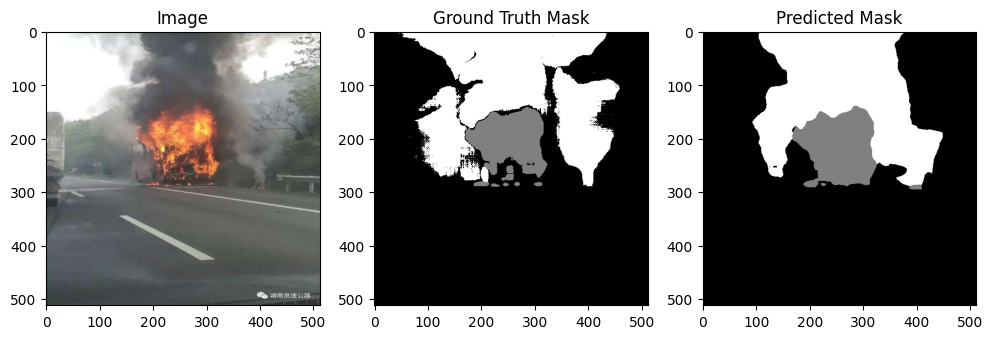

In [ ]:
import torchvision.transforms as T
torch.cuda.empty_cache()

CONFIDENCE_THRESHOLD = 0.5

def predict(model, image, device='cuda'):
    model.to(device)
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        logits = model(image)
        probs = torch.softmax(logits, dim=1)
        # For each class, create a mask where prob > threshold
        masks = (probs > CONFIDENCE_THRESHOLD).squeeze(0)
        out_mask = torch.zeros_like(masks[0], dtype=torch.long)
        for cls in range(1, probs.shape[1]):
            out_mask[masks[cls]] = cls
        return out_mask.cpu().numpy()
    
def visualize_prediction(image, mask, prediction):
    # Inverse normalization transform for visualization
    inv_transform = T.Normalize(
        mean=[-m/s for m, s in zip(mean, std)],
        std=[1/s for s in std]
    )
    image = inv_transform(image)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image.permute(1, 2, 0).numpy())
    
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(mask.numpy(), cmap='gray', vmin=0, vmax=2)
    
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(prediction, cmap='gray', vmin=0, vmax=2)
    
    plt.show()

model.load_state_dict(torch.load('./checkpoints/epoch_19.pth', weights_only=True))
model.eval()
test_dataset = COCOSegDataset(VAL_DIR, VAL_MASKS_DIR, 
                              transform=get_validation_augmentation(IMAGE_SIZE, mean, std))
image, mask = test_dataset[32]
prediction = predict(model, image, device=device)
visualize_prediction(image, mask, prediction)

In [24]:
torch.cuda.empty_cache()
del model